### imports

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
from scipy.stats import pearsonr

from sklearn.linear_model import Ridge

### load MNIST dataset

In [2]:
data = load_digits()
x,y = data['data'], data['target']

1797 images by 64 pixels

In [3]:
x.shape, y.shape

((1797, 64), (1797,))

pixel values are between 0 and 16

In [4]:
x.min(), x.max()

(0.0, 16.0)

### build the and fit the autoencoder neural network

In [5]:
model = Sequential()

model.add(Dense(32, input_dim=64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))

model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])

model.fit(x, x, epochs=100, batch_size=30)

Epoch 1/100
60/60 [==============================] - 1s 1ms/step - loss: 39.6440 - accuracy: 0.0161
Epoch 2/100
60/60 [==============================] - 0s 1ms/step - loss: 23.1264 - accuracy: 0.1191
Epoch 3/100
60/60 [==============================] - 0s 1ms/step - loss: 18.7786 - accuracy: 0.1119
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 16.2663 - accuracy: 0.0863
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 13.7089 - accuracy: 0.0874
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 12.1026 - accuracy: 0.0979
Epoch 7/100
60/60 [==============================] - 0s 2ms/step - loss: 11.1522 - accuracy: 0.1113
Epoch 8/100
60/60 [==============================] - 0s 2ms/step - loss: 10.3093 - accuracy: 0.1191
Epoch 9/100
60/60 [==============================] - 0s 2ms/step - loss: 9.6576 - accuracy: 0.1157
Epoch 10/100
60/60 [==============================] - 0s 2ms/step - loss: 9.1457 - accuracy: 0.1130
E

60/60 [==============================] - 0s 1ms/step - loss: 6.5625 - accuracy: 0.1258
Epoch 83/100
60/60 [==============================] - 0s 2ms/step - loss: 6.5696 - accuracy: 0.1247
Epoch 84/100
60/60 [==============================] - 0s 2ms/step - loss: 6.5624 - accuracy: 0.1269
Epoch 85/100
60/60 [==============================] - 0s 2ms/step - loss: 6.5619 - accuracy: 0.1174
Epoch 86/100
60/60 [==============================] - 0s 2ms/step - loss: 6.5679 - accuracy: 0.1152
Epoch 87/100
60/60 [==============================] - 0s 2ms/step - loss: 6.5569 - accuracy: 0.1196
Epoch 88/100
60/60 [==============================] - 0s 2ms/step - loss: 6.5655 - accuracy: 0.1146
Epoch 89/100
60/60 [==============================] - 0s 2ms/step - loss: 6.5549 - accuracy: 0.1196
Epoch 90/100
60/60 [==============================] - 0s 2ms/step - loss: 6.5475 - accuracy: 0.1169
Epoch 91/100
60/60 [==============================] - 0s 1ms/step - loss: 6.5517 - accuracy: 0.1263
Epoch 92/100


### evaluate the output using MSE

In [6]:
# ae stands for auto encoder
ae_pred = model.predict(x)

In [7]:
mean_squared_error(x, ae_pred)

6.514208013529163

### build a PCA model to compare

In [8]:
pca = PCA(n_components=16)

pca_latent_features = pca.fit_transform(x)
pca_pred = pca_latent_features @ pca.components_

In [9]:
pca_pred.shape

(1797, 64)

In [10]:
mean_squared_error(x, pca_pred)

44.11100492810492

after reconstruction of the data by both pca and autoencoder, we find that the autocencoder managed to get back the originial image with a lower mean sqaured error

PCA MSE: 44.1
AE MSE: 9.8

### scale the reconstructed pixel values from 0-16 to 0-1 using Min Max Scaler

In [11]:
x = MinMaxScaler().fit_transform(x)
ae_pred = MinMaxScaler().fit_transform(ae_pred)
pca_pred = MinMaxScaler().fit_transform(pca_pred)

x.min(), x.max(), ae_pred.min(), ae_pred.max(), pca_pred.min(), pca_pred.max()

(0.0, 1.0, 0.0, 1.0, 0.0, 1.0000000000000002)

### visually compare PCA reconstruction with Autoendcoder output
the output that the autoencoder yeilds is better than that of the PCA

<Figure size 200x200 with 0 Axes>

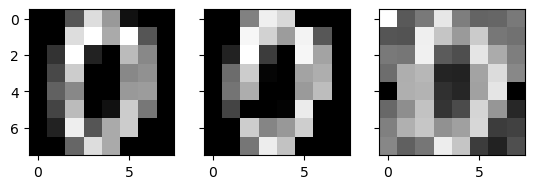

<Figure size 200x200 with 0 Axes>

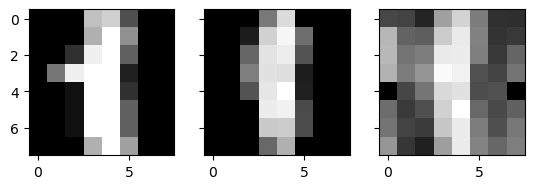

<Figure size 200x200 with 0 Axes>

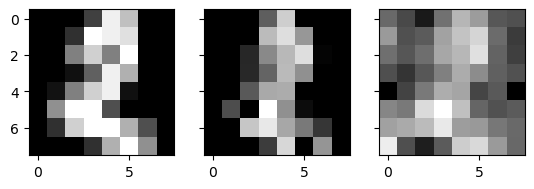

<Figure size 200x200 with 0 Axes>

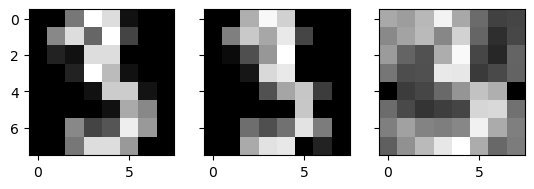

<Figure size 200x200 with 0 Axes>

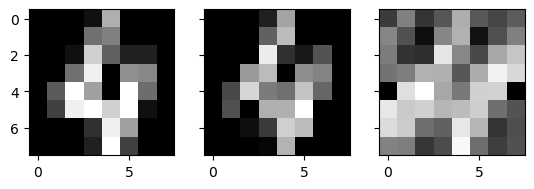

<Figure size 200x200 with 0 Axes>

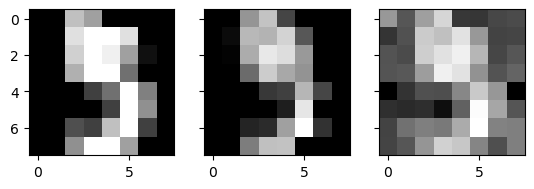

<Figure size 200x200 with 0 Axes>

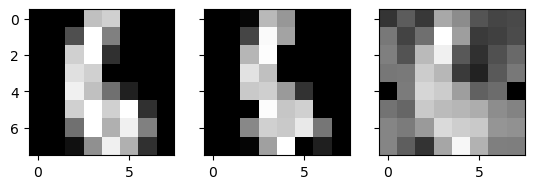

<Figure size 200x200 with 0 Axes>

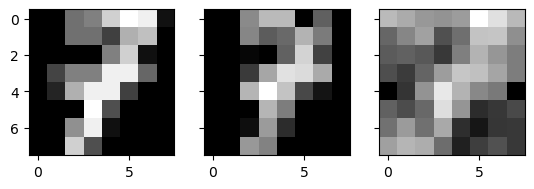

<Figure size 200x200 with 0 Axes>

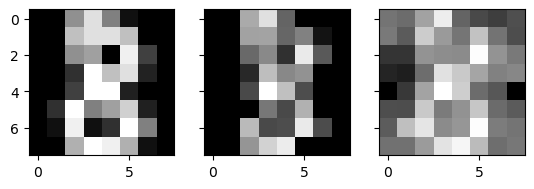

<Figure size 200x200 with 0 Axes>

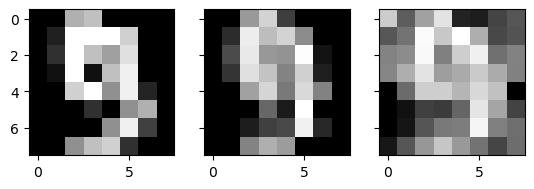

In [12]:
for i in range(10):
    plt.figure(figsize=(2,2))
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    ax1.imshow(x[i].reshape(8,8), cmap='gray')
    ax2.imshow(ae_pred[i].reshape(8,8), cmap='gray')
    ax3.imshow(pca_pred[i].reshape(8,8), cmap='gray')
    plt.show()

In [13]:
pca_latent_features.shape

(1797, 16)

### pop the last layers to get the latent features

In [14]:
model.pop()
model.pop()
model.compile(loss='MSE', optimizer='adam', metrics=['accuracy'])

In [15]:
# autoencoder latent features
ae_latent_features = model.predict(x)

### we will run a regression on both PCA & AE latent features to predict the label on them.
we will iterate 100 times for each of the models and store the R-sqaured score

In [16]:
model_inputs = {
    'pca': pca_latent_features,
    'autoencoders': ae_latent_features
}

model_outputs = {
    'pca': [],
    'autoencoders': []
}


for i in range(100):
    for model_name, features in model_inputs.items():
        labels = y

        features, labels = shuffle(features, labels)

        train_len = int(len(labels)*0.7)

        x_train = features[:train_len]
        y_train = labels[:train_len]
        x_test = features[train_len:]
        y_test = labels[train_len:]


        clf = SGDClassifier(max_iter=1000, tol=1e-3)
        clf.fit(x_train, y_train)


        lm = Ridge()
        lm.fit(x_train, y_train)



        model_outputs[model_name] += [clf.score(x_test,y_test)]

    

In [17]:
print(
    'pca average score',
    round(np.array(model_outputs['pca']).mean(), 2)
)

print(
    'autoencoders average score',
    round(np.array(model_outputs['autoencoders']).mean(), 2)
)

pca average score 0.93
autoencoders average score 0.89


--------------------------------------------------------------------------------------------------------------------
for each iteration of the 100 iterations, the ridge regression produces slightly different results. On average, pca permormed better since the R-squared is higher by 0.03. To understand whether is 0.03 is statistically significant, we will visually inspect it using a histogram

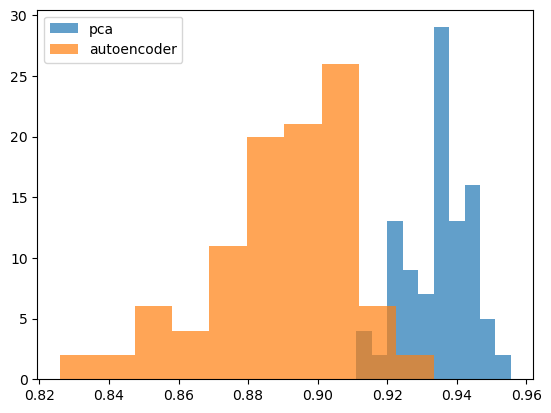

In [18]:
plt.hist(model_outputs['pca'], alpha=0.7)
plt.hist(model_outputs['autoencoders'], alpha=0.7)
plt.legend(['pca','autoencoder'])
plt.show()

### PCA clearly has better results, and the predictions using it's features are more stable when compared to the autoencoder